In [ ]:
<h1 align="center">TAREA 1: Sistemas Recomendadores </h1>

<h3 align="left">Integrantes:</h3>
<p align="left">- Martín Jara</p>
<p align="left">- Joaquín Fuentealba</p>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
articles = 'articles.xlsx'
customers = 'customers.xlsx'
transaction_val = 'transactions_val.xlsx'
users_test = 'users_test.xlsx'
transactions_train = 'transactions_train.csv'

In [3]:
# df_articles = pd.read_excel(articles)
# df_customers = pd.read_excel(customers)
# df_transaction_val = pd.read_excel(transaction_val)
# df_users_test = pd.read_excel(users_test)
df_transaction_train = pd.read_csv(transactions_train)

In [4]:
df_transaction_train

,Unnamed: 0,t_dat,customer_id,article_id,price,sales_channel_id
0,0,2018-11-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,655265001,0.025407,2
1,1,2018-11-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,537688014,0.050831,2
2,2,2019-03-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,698877002,0.042356,2
3,3,2019-03-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,382127027,0.032186,2
4,4,2019-03-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,610776001,0.008458,2
...,...,...,...,...,...,...
1318496,1318496,2019-09-10,3c0c198b6c04d50b639ca8128c3010603f34b37896bbf8...,751478002,0.042356,2
1318497,1318497,2019-09-20,3c0c198b6c04d50b639ca8128c3010603f34b37896bbf8...,750444005,0.059305,1
1318498,1318498,2019-09-20,3c0c198b6c04d50b639ca8128c3010603f34b37896bbf8...,811198001,0.033881,1
1318499,1318499,2019-09-20,3c0c198b6c04d50b639ca8128c3010603f34b37896bbf8...,787880005,0.050831,1


# Actividad 1

## Grafique la distribucion del numero de compras por usuario, identifique los ids de los 10 usuarios mas activos en el dataset. Comente la forma de la distribucion obtenida y que porcentaje de las interacciones han sido hechas por estos 10 usuarios.

In [16]:
agrupado_compras_por_usuario = df_transaction_train.groupby(['customer_id']).size().reset_index(name='compras_por_usuario')
agrupado_compras_por_usuario = agrupado_compras_por_usuario.sort_values(by='compras_por_usuario', ascending=False)

### 10 usuarios mas activos:

In [17]:
agrupado_compras_por_usuario.head(10)

,customer_id,compras_por_usuario
29300,a65f77281a528bf5c1e9f270141d601d116e1df33bf9df...,1346
23387,84c34f4f564db1f437943c77af41f83bf6fd7c01701cbb...,950
40316,e55d5ddb3a0c3fb1b4df8edbf526ba12989ab2a852c727...,910
8155,2df54f0d0653811fe06479c93905f3e6ecc6d07edf39d8...,875
28011,9f12a01e2982f70a820b5dd61528bf769b94c5c5e43b23...,789
33036,bbebb44478948f5052c3f4c5dc04f08653e7938886a856...,740
37241,d3b5f70ec21ad1718cf4951445e97007de0d4e85c39ea9...,724
30502,ad3090d52d11671ffb43bfaa85e3620eff669e8c92c911...,670
244,0152d53f51444891ea07013fd1fb8325415bb09bb6798a...,664
315,01a4717d38b651e46dda7f1ab8d1494af2682a847fa9a5...,651


Porcentaje de interacciones hechas por los 10 usuarios mas activos:

In [21]:
# transfrom to percentage
(agrupado_compras_por_usuario.head(10)['compras_por_usuario'].sum()/agrupado_compras_por_usuario["compras_por_usuario"].sum())*100

0.6309437763035447

### Distribución del número de compras por usuario

In [41]:
cantidad_usuario_por_numero_de_compras = agrupado_compras_por_usuario.groupby(['compras_por_usuario']).size().reset_index(name='cantidad_usuario_por_compras')
cantidad_usuario_por_numero_de_compras['percentage'] = cantidad_usuario_por_numero_de_compras['cantidad_usuario_por_compras'] / cantidad_usuario_por_compras['cantidad_usuario_por_compras'].sum() * 100
#cantidad_usuario_por_numero_de_compras

In [30]:
def rango_compras_por_usuario(compras_por_usuario):
    if compras_por_usuario == 2:
        return 2
    elif compras_por_usuario == 3:
        return 3
    elif compras_por_usuario == 4:
        return 4
    elif compras_por_usuario == 5:
        return 5
    elif compras_por_usuario == 6:
        return 6
    elif compras_por_usuario == 7:
        return 7
    elif compras_por_usuario == 8:
        return 8
    elif compras_por_usuario == 9:
        return 9
    else:
        return 10
    
cantidad_usuario_por_numero_de_compras['rango'] = cantidad_usuario_por_numero_de_compras['compras_por_usuario'].apply(rango_compras_por_usuario)    

In [40]:
cantidad_usuario_por_numero_de_compras_agrupado = cantidad_usuario_por_numero_de_compras.groupby(['rango']).sum().reset_index()

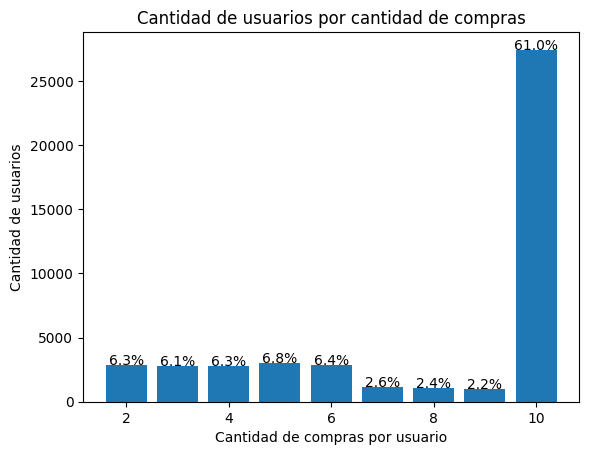

In [39]:
# Datos
rango = cantidad_usuario_por_numero_de_compras_agrupado['rango']
cantidad_usuarios = cantidad_usuario_por_numero_de_compras_agrupado['cantidad_usuario_por_compras']
porcentaje = cantidad_usuario_por_numero_de_compras_agrupado['percentage']

# Graficar
plt.bar(rango, cantidad_usuarios)
plt.xlabel('Cantidad de compras por usuario')
plt.ylabel('Cantidad de usuarios')
plt.title('Cantidad de usuarios por cantidad de compras')

# Mostrar porcentaje encima de cada barra
for i in range(len(rango)):
    plt.text(rango[i], cantidad_usuarios[i] + 0.5, f'{round(porcentaje[i], 1)}%', ha='center')

plt.show()


In [ ]:
agrupado_prod = df_transaction_train.groupby(['article_id']).size().reset_index(name='count')
agrupado_prod

,article_id,count
0,108775015,550
1,108775044,359
2,108775051,10
3,110065001,48
4,110065002,26
...,...,...
73075,946748004,11
73076,946764003,4
73077,946827001,3
73078,947509001,3


In [ ]:
agrupado_prod = agrupado_prod.sort_values(by='count', ascending=False)
agrupado_prod.head(10)

,article_id,count
36789,706016001,1978
36790,706016002,1357
14906,610776002,1302
1174,372860001,1225
49637,759871002,1010
1548,399223001,991
2540,464297007,920
8501,562245001,899
8514,562245046,849
1175,372860002,849


In [ ]:
df_users_test.head()

,Unnamed: 0,customer_id
0,0,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...
1,1,b4ba419fd5afc5eb274ab3ae1638a51a2e916b4deb0a5c...
2,2,1a1563c28f0d8781ad87f76e0a5af0485003e350f541dd...
3,3,3219f007e898957cbe0ff0f22010cd7118c06f7498a167...
4,4,4e5c03f7ffefe2f99f8e0c9d9805c1571867e6a8dd7091...


In [ ]:
df_transaction_train.head()

,Unnamed: 0,t_dat,customer_id,article_id,price,sales_channel_id
0,0,2018-11-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,655265001,0.025407,2
1,1,2018-11-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,537688014,0.050831,2
2,2,2019-03-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,698877002,0.042356,2
3,3,2019-03-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,382127027,0.032186,2
4,4,2019-03-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,610776001,0.008458,2


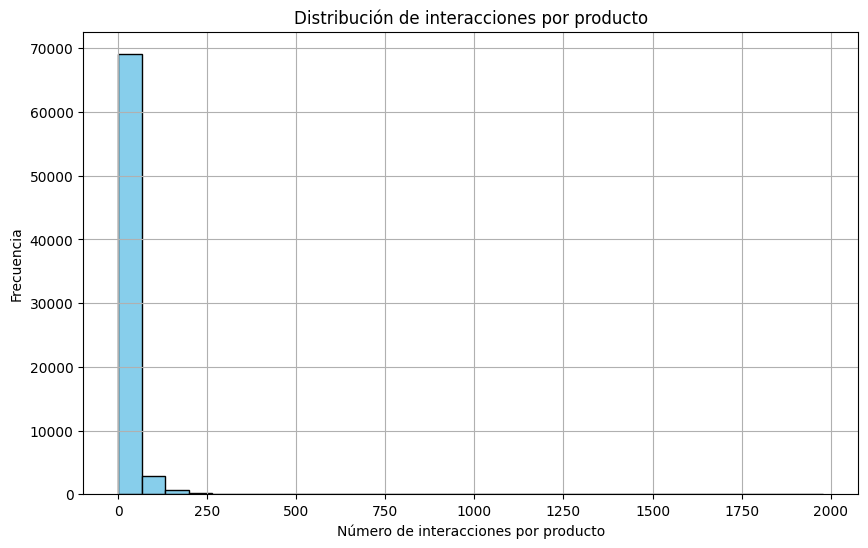

In [ ]:
# Graficar la distribución de interacciones por producto
plt.figure(figsize=(10, 6))
plt.hist(agrupado_prod['count'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Número de interacciones por producto')
plt.ylabel('Frecuencia')
plt.title('Distribución de interacciones por producto')
plt.grid(True)
plt.show()